In [1]:
%reload_ext autoreload
%autoreload 2

In [189]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
from neo.rawio import neuroscoperawio
import nelpy.plotting as npl
from ripple_heterogeneity.utils import scalebars
import pickle

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [342]:
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day10.pkl"
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_AYAold_AYA9_day15.pkl"

# Z:\Data\AYAold\AYA9\day15
with open(session, "rb") as f:
    results = pickle.load(f)


In [343]:
from xml.etree import ElementTree


def parse_xml_channel_groups(filename):
    filename = filename.replace(".xml", "").replace(".dat", "")

    tree = ElementTree.parse(filename + ".xml")
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
        root.find("anatomicalDescription").find("channelGroups").findall("group")
    ):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text), grp_index])
    return np.array(channel_group)


reader = neuroscoperawio.NeuroScopeRawIO("Z:/Data/HMC1/day10/day10")
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:, 1] == shank, 0]


In [339]:
channel_indexes


array([288, 301, 306, 319, 302, 305, 289, 303, 304, 290, 300, 307, 291,
       299, 308, 292, 298, 309, 293, 297, 310, 318, 296, 311, 317, 295,
       312, 316, 294, 313, 315, 314])

In [346]:
channel_indexes = [293, 314]
rip = 1
seconds_idx = np.array(
    [results["react"].ripples[rip].start, results["react"].ripples[rip].stop]
)

# convert to index
to_idx = (seconds_idx * reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(
    i_start=to_idx[0], i_stop=to_idx[1], channel_indexes=channel_indexes
)


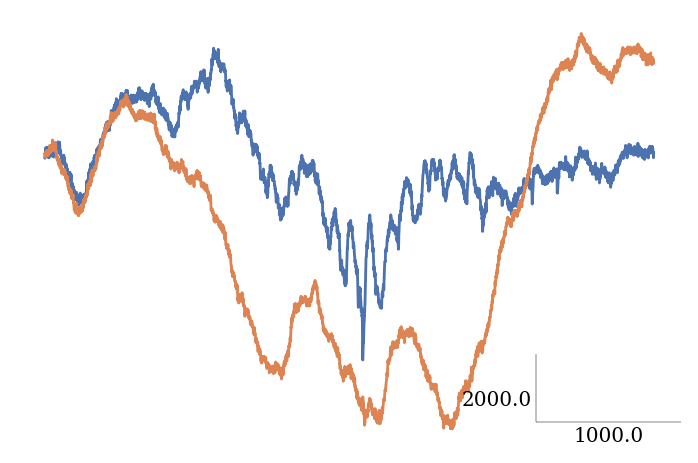

In [347]:
plt.plot(raw_sigs)
sb = scalebars.add_scalebar(plt.gca())


In [12]:
results


{'assembly_act_pre': <AnalogSignalArray at 0x1f265093490: 45 signals (4,052 segments)> for a total of 12:33:524 minutes,
 'assembly_act_task': <AnalogSignalArray at 0x1f26509d8e0: 45 signals (776 segments)> for a total of 2:11:762 minutes,
 'assembly_act_post': <AnalogSignalArray at 0x1f26509dbe0: 45 signals (5,227 segments)> for a total of 16:20:389 minutes,
 'react': <ripple_heterogeneity.assembly.assembly_reactivation.AssemblyReact at 0x1f26509de20>}

In [13]:
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [82]:
df_strength = assembly_multi_region.load_reactivation(results)

labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

out = [labels[val] for val in np.argmax(df_strength[labels].values, axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[
    df_strength.single_cross_region == False, "single_cross_region_label"
] = "unknown"

deep_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_mec"
].assembly_n.unique()
deep_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_pfc"
].assembly_n.unique()
superficial_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_mec"
].assembly_n.unique()
superficial_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_pfc"
].assembly_n.unique()
other_assemblies = df_strength[
    df_strength.single_cross_region == False
].assembly_n.unique()


In [131]:
deep_mec_assem_n, deep_pfc_assem_n, superficial_mec_assem_n, superficial_pfc_assem_n, other_assemblies


(array([], dtype=float64),
 array([ 4., 13., 19.]),
 array([], dtype=float64),
 array([32.]),
 array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14.,
        15., 16., 17., 18., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30., 31., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
        43., 44.]))

In [283]:
# df_strength[df_strength.single_cross_region_label == "deep_pfc"].iloc[np.argsort(-df_strength[df_strength.single_cross_region_label == "deep_pfc"].strength)]


In [282]:
# temp_df = df_strength.copy()
# offset = 0
# for epoch in temp_df.epoch.unique():
#     temp_df.loc[temp_df.epoch == epoch, "ripple_n"] = (
#         temp_df[temp_df.epoch == epoch].ripple_n.values + offset
#     )
#     # update offset
#     offset = temp_df[temp_df.epoch == epoch].ripple_n.max() + 1

# # temp_df[temp_df.single_cross_region_label == "deep_pfc"].iloc[np.argsort(-temp_df[temp_df.single_cross_region_label == "deep_pfc"].strength)]

# temp_df[
#     (temp_df.single_cross_region_label == "deep_pfc") & (temp_df.epoch == "post")
# ].iloc[
#     np.argsort(
#         -temp_df[
#             (temp_df.single_cross_region_label == "deep_pfc")
#             & (temp_df.epoch == "post")
#         ].strength
#     )
# ]


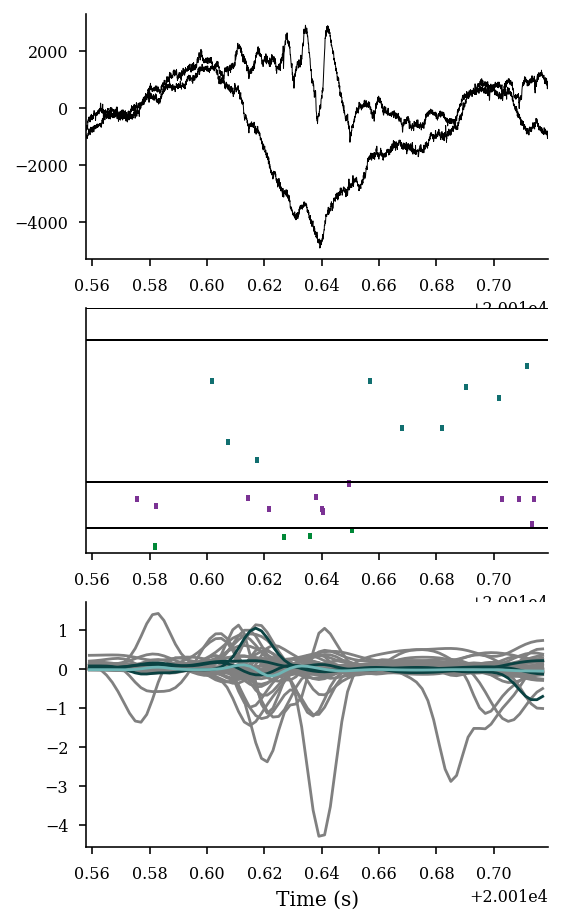

In [281]:
rip = 9930

fig, axs = plt.subplots(
    3,
    1,
    figsize=functions.set_size("thesis", fraction=0.7, subplots=(3, 1)),
    edgecolor=None,
)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
axs = axs.ravel()

# plot raw signal
channel_indexes = [293, 314]

seconds_idx = np.array(
    [results["react"].ripples[rip].start, results["react"].ripples[rip].stop]
)
# convert to index
to_idx = (seconds_idx * reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(
    i_start=to_idx[0], i_stop=to_idx[1], channel_indexes=channel_indexes
)
ts = np.linspace(
    results["react"].ripples[rip].start,
    results["react"].ripples[rip].stop,
    raw_sigs.shape[0],
)

axs[0].plot(ts, raw_sigs, color="k", linewidth=0.5)
# scalebars.add_scalebar(axs[0])

# plot raster
group_colors = {
    "MEC": "#de2020",
    "PFC": "#116f70",
    "Deep": "#7b3294",
    "Superficial": "#008837",
}
group_colors_assemblies = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#0a4242",  #  "#116f70"
    "superficial_pfc": "#6eb5b5",  # "#568c8c"
}
ca1_deep_idx = results["react"].cell_metrics.brainRegion.str.contains("CA1") & results[
    "react"
].cell_metrics.deepSuperficial.str.contains("Deep")
ca1_sup_idx = results["react"].cell_metrics.brainRegion.str.contains("CA1") & results[
    "react"
].cell_metrics.deepSuperficial.str.contains("Superficial")
pfc_idx = results["react"].cell_metrics.brainRegion.str.contains("PFC")
mec_idx = results["react"].cell_metrics.brainRegion.str.contains("MEC")

npl.rasterplot(
    results["react"].st.iloc[:, ca1_sup_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Superficial"],
    vertstack=True,
)

ymin, ymax = axs[1].get_ylim()
axs[1].axhline(ymax, color="k", linewidth=1)

npl.rasterplot(
    results["react"].st.iloc[:, ca1_deep_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Deep"],
    vertstack=True,
)
ymin, ymax = axs[1].get_ylim()
axs[1].axhline(ymax, color="k", linewidth=1)

npl.rasterplot(
    results["react"].st.iloc[:, pfc_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["PFC"],
    vertstack=True,
)
ymin, ymax = axs[1].get_ylim()
axs[1].axhline(ymax, color="k", linewidth=1)
npl.rasterplot(
    results["react"].st.iloc[:, mec_idx][results["react"].ripples[rip]],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["MEC"],
    vertstack=True,
)
ymin, ymax = axs[1].get_ylim()
axs[1].axhline(ymax, color="k", linewidth=1)

# plot assembly strength
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]]
    .data[other_assemblies.astype(int), :]
    .T,
    color="grey",
)
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]]
    .data[deep_pfc_assem_n.astype(int), :]
    .T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]]
    .data[superficial_pfc_assem_n.astype(int), :]
    .T,
    color=group_colors_assemblies["superficial_pfc"],
)
sns.despine()
axs[2].set_xlabel("Time (s)")

for ax in axs:
    ax.set_xlim(results["react"].ripples[rip].start, results["react"].ripples[rip].stop)

axs[1].axes.get_yaxis().set_visible(False)


## plot assembly strength examples

### plot pfc assembly strength plots

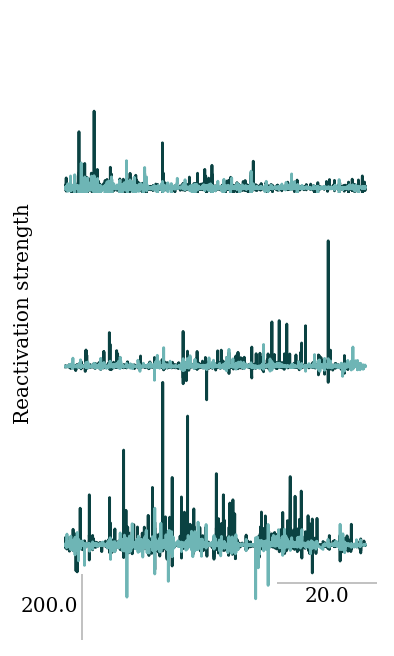

In [257]:
fig, axs = plt.subplots(
    3,
    1,
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)),
    edgecolor=None,
    sharey=True,
)
fig.subplots_adjust(hspace=-0.25, wspace=0.1)
axs = axs.ravel()
fig.patch.set_alpha(0)

epoch = nel.EpochArray(
    [
        results["assembly_act_pre"].abscissa_vals.min(),
        results["assembly_act_pre"].abscissa_vals.min() + 60 * 60,
    ]
)

axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[deep_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[superficial_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_pfc"],
)

epoch = nel.EpochArray(
    [
        results["assembly_act_task"].abscissa_vals.min(),
        results["assembly_act_task"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[1].plot(
    results["assembly_act_task"][epoch].abscissa_vals / 60,
    results["assembly_act_task"][epoch].data[deep_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[1].plot(
    results["assembly_act_task"].abscissa_vals / 60,
    results["assembly_act_task"].data[superficial_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_pfc"],
)

epoch = nel.EpochArray(
    [
        results["assembly_act_post"].abscissa_vals.min(),
        results["assembly_act_post"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[deep_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[superficial_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_pfc"],
)

scalebars.add_scalebar(axs[2], loc="lower right", matchx=True, matchy=False)
scalebars.add_scalebar(
    axs[2], loc="lower left", matchx=False, matchy=True, borderpad=-2
)

sns.despine(bottom=True, left=True)
axs[0].axes.get_yaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[2].axes.get_yaxis().set_visible(False)
axs[0].axes.get_xaxis().set_visible(False)
axs[1].axes.get_xaxis().set_visible(False)
axs[2].axes.get_xaxis().set_visible(False)

fig.text(0.04, 0.5, "Reactivation strength", va="center", rotation="vertical")

plt.savefig(
    os.path.join(fig_save_path, "react_example_cross_region_PFC.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)


### mec example

In [307]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress"
prop_df, assembly_df, df_strength = assembly_multi_region.load_results(save_path)


Loading results...


In [309]:
labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

out = [labels[val] for val in np.argmax(df_strength[labels].values, axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[
    df_strength.single_cross_region == False, "single_cross_region_label"
] = "unknown"


### locate sessons with sup to mec and deep to mec assemblies

In [315]:
for basepath in df_strength.basepath.unique():
    deep_mec_assem_n = df_strength[
        (df_strength.single_cross_region_label == "deep_mec")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    deep_pfc_assem_n = df_strength[
        (df_strength.single_cross_region_label == "deep_pfc")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    superficial_mec_assem_n = df_strength[
        (df_strength.single_cross_region_label == "superficial_mec")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    superficial_pfc_assem_n = df_strength[
        (df_strength.single_cross_region_label == "superficial_pfc")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    # other_assemblies = df_strength[df_strength.single_cross_region == False].assembly_n.unique()
    if any(deep_mec_assem_n) & any(superficial_mec_assem_n):
        print(basepath)


Z:\Data\AYAold\AYA9\day16
Z:\Data\Kenji\ec013.634_653
Z:\Data\Kenji\ec016.281_298


In [353]:
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress\Z__Data_AYAold_AYA9_day16.pkl"
# "Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress\Z__Data_Kenji_ec013.634_653.pkl"
# "Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress\Z__Data_Kenji_ec016.281_298.pkl"

with open(session, "rb") as f:
    results = pickle.load(f)

df_strength = assembly_multi_region.load_reactivation(results)

labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

out = [labels[val] for val in np.argmax(df_strength[labels].values, axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[
    df_strength.single_cross_region == False, "single_cross_region_label"
] = "unknown"

deep_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_mec"
].assembly_n.unique()
deep_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_pfc"
].assembly_n.unique()
superficial_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_mec"
].assembly_n.unique()
superficial_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_pfc"
].assembly_n.unique()
other_assemblies = df_strength[
    df_strength.single_cross_region == False
].assembly_n.unique()

deep_mec_assem_n, deep_pfc_assem_n, superficial_mec_assem_n, superficial_pfc_assem_n, other_assemblies


(array([4.]),
 array([], dtype=float64),
 array([10., 13.]),
 array([], dtype=float64),
 array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 11., 12., 14.]))

### plot mec example

In [359]:
# plt.plot(results.get("react").patterns[4,:])
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)

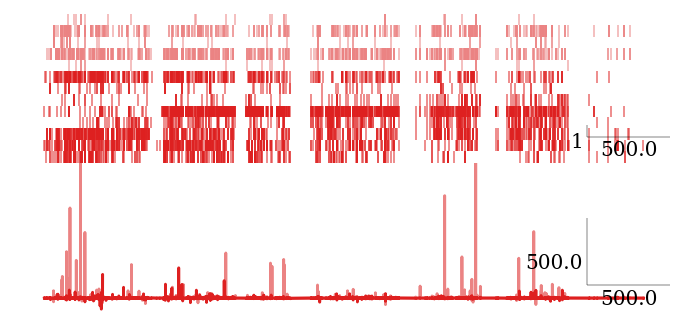

<Figure size 432x288 with 0 Axes>

In [392]:
fig, axs = plt.subplots(2,1,
    figsize=functions.set_size("thesis", fraction=1, subplots=(1.5, 2)),
    edgecolor=None,
    sharex=True,
)
fig.subplots_adjust(hspace=0, wspace=0.1)
axs = axs.ravel()
fig.patch.set_alpha(0)

epoch = nel.EpochArray(
    [
        results["assembly_act_post"].abscissa_vals.min(),
        results["assembly_act_post"].abscissa_vals.min() + 60 * 60,
    ]
)
results.get("react").ripples

group_colors_assemblies = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#0a4242",  #  "#116f70"
    "superficial_pfc": "#6eb5b5",  # "#568c8c"
}
plt.figure()
npl.rasterplot(
    results["react"].st.iloc[:, is_member[4, :]][results.get("react").ripples][epoch],
    lw=1,
    lh=1,
    ax=axs[0],
    color=group_colors_assemblies["deep_mec"],
    vertstack=True,
    alpha=0.5,
)
npl.rasterplot(
    results["react"].st.iloc[:, is_member[10, :] | is_member[13, :]][
        results.get("react").ripples
    ][epoch],
    lw=1,
    lh=1,
    ax=axs[0],
    color=group_colors_assemblies["superficial_mec"],
    vertstack=True,
    alpha=0.5,
)
# sns.despine(bottom=True, left=True)
axs[1].plot(
    results["assembly_act_post"][epoch].abscissa_vals,
    results["assembly_act_post"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[1].plot(
    results["assembly_act_post"][epoch].abscissa_vals,
    results["assembly_act_post"][epoch].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)
axs[1].set_ylim(-100, 1000)

scalebars.add_scalebar(axs[0])
scalebars.add_scalebar(axs[1])

# scalebars.add_scalebar(axs[0], loc="lower right", matchx=True, matchy=False)
# scalebars.add_scalebar(axs[0], loc="lower left", matchx=False, matchy=True, borderpad=-2)
# scalebars.add_scalebar(axs[1], loc="lower right", matchx=True, matchy=False)
# scalebars.add_scalebar(axs[1], loc="lower left", matchx=False, matchy=True, borderpad=-2)

# axs[0].axes.get_yaxis().set_visible(False)
# axs[1].axes.get_yaxis().set_visible(False)
# axs[0].axes.get_xaxis().set_visible(False)
# axs[1].axes.get_xaxis().set_visible(False)

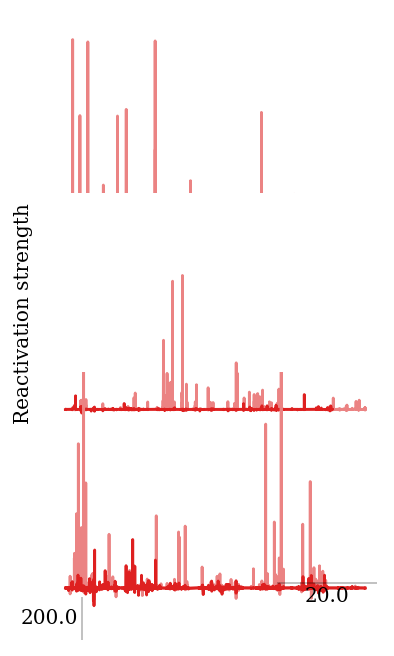

In [329]:
fig, axs = plt.subplots(3,1,
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)),
    edgecolor=None,
    sharey=True,
)
fig.subplots_adjust(hspace=-0.25, wspace=0.1)
axs = axs.ravel()
fig.patch.set_alpha(0)

epoch = nel.EpochArray(
    [
        results["assembly_act_pre"].abscissa_vals.min(),
        results["assembly_act_pre"].abscissa_vals.min() + 60 * 60,
    ]
)

axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)

epoch = nel.EpochArray(
    [
        results["assembly_act_task"].abscissa_vals.min(),
        results["assembly_act_task"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[1].plot(
    results["assembly_act_task"][epoch].abscissa_vals / 60,
    results["assembly_act_task"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[1].plot(
    results["assembly_act_task"].abscissa_vals / 60,
    results["assembly_act_task"].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)

epoch = nel.EpochArray(
    [
        results["assembly_act_post"].abscissa_vals.min(),
        results["assembly_act_post"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)

axs[0].set_ylim(-100, 1000)

scalebars.add_scalebar(axs[2], loc="lower right", matchx=True, matchy=False)
scalebars.add_scalebar(
    axs[2], loc="lower left", matchx=False, matchy=True, borderpad=-2
)

sns.despine(bottom=True, left=True)
axs[0].axes.get_yaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[2].axes.get_yaxis().set_visible(False)
axs[0].axes.get_xaxis().set_visible(False)
axs[1].axes.get_xaxis().set_visible(False)
axs[2].axes.get_xaxis().set_visible(False)

fig.text(0.04, 0.5, "Reactivation strength", va="center", rotation="vertical")

plt.savefig(
    os.path.join(fig_save_path, "react_example_cross_region_MEC.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
